In [ ]:
import numpy as np
import torch
a= torch.tensor([[0,1],[1,0],[1,0],[1,0]])

In [ ]:
print(a)

In [ ]:
import os
from src.utils.checkpoints import push_checkpoint_to_image_server

ckpt_name = 'ssl-pretrain_all-centers_no-prst_ndl_crop'
CHECKPOINT_PATH = '/home/mahdigilany/offline_codes/codes/TRUSnet/logs/experiments/runs/' \
                      'ssl-pretrain_all-centers_no-prst_ndl_crop'

split_seed = 3
epoch='epoch_076.ckpt'
ckpt_path = os.path.join(CHECKPOINT_PATH, '2022-10-18_22-40-44')
ckpt_path = os.path.join(ckpt_path, 'checkpoints', epoch)

push_checkpoint_to_image_server(checkpoint_name=ckpt_name+f'_{split_seed}', checkpoint_path=ckpt_path)

## load sl sll baselines IPCAI

In [ ]:
from src.utils.checkpoints import get_named_checkpoint
split_seed = 0
seed = 0
ckpt_name = f"finetune-semi-sup_all-centrs_ssl-pretrain_all-centrs_ssd_{split_seed}_gsd_{seed}"
ckpt_path = get_named_checkpoint(ckpt_name)

import torch
checkpoint = torch.load(ckpt_path)

class _Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        from src.lightning.lightning_modules.self_supervised.finetune import Finetuner
        from omegaconf import OmegaConf
        from dataclasses import dataclass

        @dataclass
        class Backbone:
          _target_: str = "src.modeling.registry.create_model"
          model_name: str = "vicreg_resnet10_pretrn_allcntrs_noPrst_ndl_crop"
          split_seed: int = 0

        backbone_conf = OmegaConf.structured(Backbone(split_seed=split_seed))
        model = Finetuner.load_from_checkpoint(ckpt_path, backbone=backbone_conf)

        self.backbone = model.backbone
        self.linear_layer = model.linear_layer

    def forward(self, x):
        features = self.backbone.forward(x)
        output = self.linear_layer(features)
        return output

model = _Model()
# model.load_state_dict(checkpoint['state_dict'])

In [ ]:
from omegaconf import OmegaConf
from dataclasses import dataclass
from src.lightning.lightning_modules.self_supervised.finetune import Finetuner

@dataclass
class Backbone:
  _target_: str = "src.modeling.registry.create_model"
  model_name: str = "vicreg_resnet10_pretrn_allcntrs_noPrst_ndl_crop"
  split_seed: int = 0

backbone_conf = OmegaConf.structured(Backbone)
print(OmegaConf.to_yaml(backbone_conf))


In [ ]:
from src.utils.checkpoints import get_named_checkpoint
split_seed = 0
seed = 0
ckpt_name = f"finetune-semi-sup_all-centrs_ssl-pretrain_all-centrs_ssd_{split_seed}_gsd_{seed}"
ckpt_path = get_named_checkpoint(ckpt_name)

import torch
checkpoint = torch.load(ckpt_path)

from src.lightning.lightning_modules.self_supervised.finetune import Finetuner
from omegaconf import OmegaConf
from dataclasses import dataclass

@dataclass
class Backbone:
  _target_: str = "src.modeling.registry.create_model"
  model_name: str = "vicreg_resnet10_pretrn_allcntrs_noPrst_ndl_crop"
  split_seed: int = 0

backbone_conf = OmegaConf.structured(Backbone(split_seed=split_seed))
model = Finetuner.load_from_checkpoint(ckpt_path, backbone=backbone_conf)

## Gleason grading


In [1]:
%cd ..
# pass environment variables to jupyter notebook.
# %env DATA=/home/mahdigilany/projects_data/Exact

/home/mahdigilany/offline_codes/codes/TRUSnet


### datamodule

In [2]:

# from hydra.utils import instantiate
# from omegaconf import OmegaConf
# from src.lightning.datamodules.exact_datamodule import ExactPatchDMConfig

# dm_config = OmegaConf.structured(ExactPatchDMConfig(_target_="src.lightning.datamodules.exact_datamodule.PatchesConcatenatedFromCoresDataModule"))
# dm = instantiate(dm_config)
# val_ds = dm.val_ds

In [3]:
import pytorch_lightning as pl
pl.seed_everything(0)

/home/mahdigilany/anaconda3/envs/exact_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


0

In [20]:
from src.lightning.datamodules.exact_datamodule import ExactPatchDMConfig
from src.configuration import register_configs
from hydra import compose, initialize
from hydra.utils import instantiate 
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
from rich import print as pprint

# dm_config = OmegaConf.structured(ExactPatchDMConfig(_target_="src.lightning.datamodules.exact_datamodule.PatchDataModuleForSupervisedLearning"))

register_configs()

GlobalHydra.instance().clear()
initialize(config_path="../configs", version_base="1.1")

dm_config = compose(
    config_name="datamodule/concatenated_cores.yaml", 
    overrides=["datamodule.splits.cohort_specifier=['UVA', 'CRCEO', 'PMCC', 'PCC']",
               "datamodule.splits.train_val_split_seed=1",
               "datamodule.splits.train_val_ratio=0.2",
               "datamodule.splits.test_as_val=True"]
    )
dm = instantiate(dm_config)
# pprint(OmegaConf.to_yaml(dm_config))

dm = dm['datamodule']
print(dm.root)
dm.setup()


/home/mahdigilany/projects_data/Exact


Loading Patch Views: 100%|██████████| 77/77 [00:00<00:00, 5803.44it/s]


In [79]:
train_dl_list = [dm.train_dataloader()]
val_dl_list = dm.val_dataloader()
test_dl_list = dm.test_dataloader()
len(val_dl_list)
# test_ds_dict = dm.test_ds

8

In [22]:
val_dl_UVA = val_dl_list[0]
test_dl_UVA = test_dl_list[0]

In [23]:
# batch = next(iter(val_dl_UVA))
# batch[2]

### model

In [87]:
from src.modeling.registry import create_model

model = create_model(model_name="grade_linear_all_centers", with_sampler=False)


/home/mahdigilany/anaconda3/envs/exact_env/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(


In [88]:
from pytorch_lightning.utilities.model_summary import ModelSummary

ModelSummary(model, max_depth=1)

  | Name         | Type               | Params
----------------------------------------------------
0 | train_acc    | Accuracy           | 0     
1 | backbone     | VICReg             | 5.7 M 
2 | head_network | MultiheadAttention | 1.1 M 
----------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.352    Total estimated model params size (MB)

### trainer/tester

In [89]:
# import pytorch_lightning as pl

# trainer = pl.Trainer(gpus=1, max_epochs=1)
# validation_epoch_end_outputs = trainer.test(model, dataloaders=test_dl_UVA)

In [90]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# accumulating logits and labels in logits_list and labels_list
logits_list = []
labels_list = []

# accumulating metadata dictionaries in a pandas dataframe 
import pandas as pd
metadata_list = []

for _loader in train_dl_list[:4]:
    for batch in _loader:
        x = batch[0].to(device)
        pos = batch[1]
        y = batch[2]
        metadata = batch[3:]
        
        loss, logits, labels, *metadata = model.shared_step(tuple([x, pos, y, *metadata]))
        
        metadata_list.append(metadata[0])
        logits_list.append(logits.detach().cpu())
        labels_list.append(labels.detach().cpu())
    
logits = torch.cat(logits_list) # (N, 3)
labels = torch.cat(labels_list) # (N,)
metadata_df = pd.DataFrame(metadata_list)

### getting performance

In [132]:
# logits.softmax(dim=1).argmax(dim=1)
# finding macro accuracy and auroc using labels and logits.
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score
acc = accuracy_score(labels, logits.softmax(dim=1).argmax(dim=1))
b_acc = balanced_accuracy_score(labels, logits.softmax(dim=1).argmax(dim=1))
auc = roc_auc_score(labels, logits.softmax(dim=1), multi_class="ovr",average=None)

print(f"acc: {acc}, b_acc: {b_acc}, auc: {auc}")

# getting the same metrics using pytorch lightning
from torchmetrics.functional.classification import accuracy, auroc
acc = accuracy(logits, labels, num_classes=3, average="none", multiclass=True)
auc = auroc(logits, labels, num_classes=3, average="None")

print(f"b_acc: {acc}, auc: {auc}")

acc: 0.6921241050119332, b_acc: 0.5691997228999126, auc: [0.81387165 0.79569021 0.77309708]
b_acc: tensor([0.7972, 0.6961, 0.2143]), auc: tensor([0.8113, 0.7905, 0.7531])


### checking predictions 

In [ ]:
import numpy as np
print(labels)
print(logits.softmax(dim=1).argmax(dim=1))
print(torch.sum(labels == 0))

### testing loading from checkpoint

In [30]:
from src.utils.checkpoints import get_named_checkpoint
from src.lightning.lightning_modules.self_supervised.finetune import CoreGradeFinetuner
from omegaconf import OmegaConf
from dataclasses import dataclass

# ckpt_name = f"grading_Multattn-sl_all-centrs_ssl-pretrain_all-centrs"
# ckpt_path = get_named_checkpoint(ckpt_name)

# ckpt_path = "./logs/experiments/runs/Grading_Multattn-sl_all-centrs_ssl-pretrain_all-centrs_bsz20/" \
#     "2022-11-29_18-15-46/checkpoints/epoch_017.ckpt"

ckpt_path = "/home/mahdigilany/projects_data/Exact/checkpoint_store/epoch_011.ckpt"


@dataclass
class Backbone:
    _target_: str = "src.modeling.registry.create_model"
    model_name: str = "vicreg_resnet10_pretrn_allcntrs_noPrst_ndl_crop"
    split_seed: int = 1

backbone_conf = OmegaConf.structured(Backbone)
model = CoreGradeFinetuner.load_from_checkpoint(ckpt_path, backbone=backbone_conf)

model_notloaded = create_model(model_name="vicreg_resnet10_pretrn_allcntrs_noPrst_ndl_crop", split_seed=1)
# print(torch.load(ckpt_path)['state_dict']['backbone.backbone.layer1.0.conv1.weight'])
# print(model_notloaded.backbone.layer1[0].conv1.weight)
# print(model.backbone.backbone.layer1[0].conv1.weight)


# instantiating head network using structured config
from omegaconf import OmegaConf
from src.lightning.lightning_modules.self_supervised.finetune import HeadNetConfig

head_config = OmegaConf.structured(HeadNetConfig)
head_network = instantiate(head_config)

print(model.head_network.linears[0].weight)
# print(head_network.linears[0].weight)

Parameter containing:
tensor([[ 1.6366e-02,  1.2715e-02,  9.7730e-03,  ..., -3.1610e-02,
          1.3288e-02,  2.8237e-06],
        [-2.7461e-02,  1.1492e-02,  3.6739e-02,  ..., -2.5170e-02,
         -2.7714e-02, -1.1655e-02],
        [-2.5266e-02,  3.5729e-02,  1.9143e-02,  ..., -1.0565e-02,
         -4.7182e-03,  3.0842e-02],
        ...,
        [-1.0982e-02,  2.7076e-02,  1.9341e-02,  ..., -2.3310e-02,
          1.5406e-03,  3.0218e-02],
        [-1.2433e-02, -1.0591e-02, -3.3257e-03,  ...,  9.9350e-03,
         -1.4610e-02, -3.1932e-03],
        [-2.2631e-02,  3.4880e-02, -1.2592e-02,  ...,  1.5350e-02,
          2.2455e-02, -2.0288e-02]], requires_grad=True)


/home/mahdigilany/anaconda3/envs/exact_env/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(


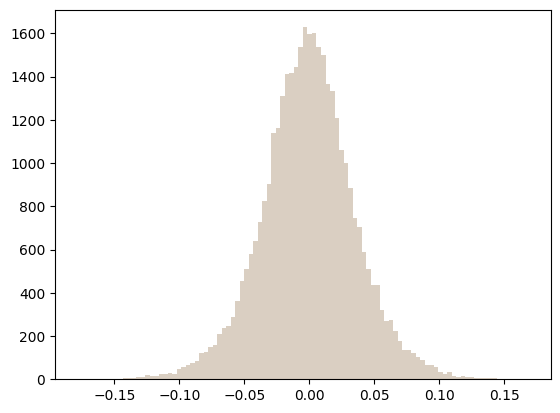

In [31]:
# plotting the histogram of the weights of the first convolutional layer of the backbone.
import matplotlib.pyplot as plt

plt.hist(model.backbone.backbone.layer1[0].conv1.weight.detach().cpu().flatten(), bins=100, alpha=0.2)
plt.hist(model_notloaded.backbone.layer1[0].conv1.weight.detach().cpu().flatten(), bins=100, alpha=0.2)
# plt.hist(torch.load(ckpt_path)['state_dict']['backbone.backbone.layer1.0.conv1.weight'].detach().cpu().flatten(),
        #  bins=100, alpha=0.2)
plt.show()


### another testing loading from checkpoint

In [32]:
from src.utils.checkpoints import get_named_checkpoint
from src.lightning.lightning_modules.self_supervised.finetune import CoreGradeFinetuner
from omegaconf import OmegaConf
from dataclasses import dataclass

# ckpt_name = f"grading_Multattn-sl_all-centrs_ssl-pretrain_all-centrs"
# ckpt_path = get_named_checkpoint(ckpt_name)

# ckpt_path = "./logs/experiments/runs/Grading_Multattn-sl_all-centrs_ssl-pretrain_all-centrs_bsz20/" \
#     "2022-11-29_18-15-46/checkpoints/epoch_017.ckpt"

ckpt_path = "/home/mahdigilany/projects_data/Exact/checkpoint_store/epoch_011.ckpt"
sd = torch.load(ckpt_path)


feat_extractor = create_model("vicreg_resnet10_pretrn_allcntrs_noPrst_ndl_crop", split_seed=1)
# print(feat_extractor.backbone.layer1[0].conv1.weight)
feat_sd = {
    k.removeprefix("backbone."): v
    for k, v in sd["state_dict"].items()
    if "backbone" in k
}
feat_extractor.load_state_dict(feat_sd)
# print(feat_extractor.backbone.layer1[0].conv1.weight)


head_net = create_model("attention_classifier", token_dim=512, num_classes=3)
# print(head_net.linears[0].weight)
head_sd = {
    k.removeprefix("head_network."): v
    for k, v in sd["state_dict"].items()
    if "head_network" in k
}
head_net.load_state_dict(head_sd)
# print(head_net.linears[0].weight)
# print(model.head_network.linears[0].weight)


<All keys matched successfully>

### Visualizing predictions

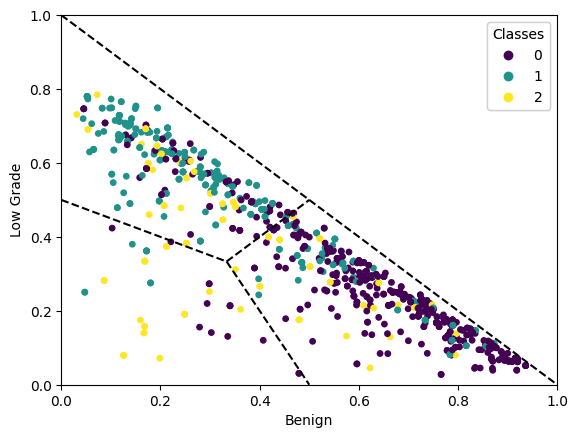

In [92]:
import matplotlib.pyplot as plt
_labels = labels.numpy()
_logits = logits.softmax(dim=1).numpy()

# plotting first and second dimension of logits with color coding based on the labels
fig, ax = plt.subplots()
# scatter = ax.scatter(_logits[:, 0], _logits[:, 1], c=_logits.argmax(axis=1), s=15,)
scatter = ax.scatter(_logits[:, 0], _logits[:, 1], c=_labels, s=15,)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

# set the scale of x and y axis to be the same from 0 to 1
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
# produce labels for the plot. x axis should be called benign and y axis should be called Low Grade
ax.set_xlabel("Benign")
ax.set_ylabel("Low Grade")

x = np.linspace(1/3, .5, 100)
y = x
ax.plot(x, y, color="black", linestyle="--")


y = 1 - 2*x
ax.plot(x, y, color="black", linestyle="--")

x = np.linspace(0, 1/3, 100)
y = 0.5 - 0.5*x
ax.plot(x, y, color="black", linestyle="--")

x = np.linspace(0, 1, 100)
y = 1 - x
ax.plot(x, y, color="black", linestyle="--")

plt.show()
# print(labels.numpy())

## from this part I just test some codes

In [40]:
import src.data.sampler as sampler
train_ds = dm.train_ds
meta_data = train_ds.metadata


In [ ]:
# I want to get grades which are in the meta_data and categorize them into 3 classes based on the following criteria:
# 1. if grade is Bening, then the label is 0
# 2. if grade is GS7, then the label is 1
# 3. if grade is GS8 or GS9 or GS10, then the label is 2
# meta_data['grade'] = meta_data['grade'].fillna(0)
import pandas as pd
# copy dataframes  
dataframe = pd.DataFrame(meta_data.copy())
# dataframe = pd.DataFrame(meta_data)
dataframe[dataframe['grade'] == 'Benign'] = 0
dataframe[dataframe['grade'] == 'GS7'] = 1
dataframe[dataframe['grade'] == 'GS8'] = 2
dataframe[dataframe['grade'] == 'GS9'] = 2
dataframe[dataframe['grade'] == 'GS10'] = 2
dataframe['grade']
dataframe['grade'] = dataframe['grade'].astype(int)
dataframe['grade']

dataframe['grade'].to_numpy()

In [131]:
# getting properties of the class train_dl
no_list = []
for dl in val_dl_list[:4]:
    no_list.append(sum(dl.dataset.metadata['grade'] == "Benign"))

print(no_list)
print(sum(no_list))

[52, 34, 15, 30]
131


### test loading model

In [4]:
%cd ..

/home/mahdigilany/offline_codes/codes/TRUSnet


In [27]:
from src.modeling.registry import create_model
from src.typing import FeatureExtractionProtocol

from src.utils.checkpoints import get_named_checkpoint
import torch

seed = 12345
split_seed = 0
ckpt_name = f"sl_CRCEO428_sd{seed}_splt{split_seed}"
ckpt_path = get_named_checkpoint(ckpt_name)

checkpoint = torch.load(ckpt_path)
state_dict = checkpoint["state_dict"]

feat_sd = {
    k.removeprefix("backbone."): v
    for k, v in state_dict.items()
    if "backbone" in k
}

feat_sd = {
    k.removeprefix("backbone."): v
    for k, v in feat_sd.items()
    if "backbone" in k
}

feat_sd.keys()

feat_extractor = create_model("resnet10_feature_extractor")

feat_extractor.load_state_dict(feat_sd)


isinstance(feat_extractor, FeatureExtractionProtocol)


True